<a href="https://colab.research.google.com/github/lizzzb/MovieLens-Data-Analysis-in-Python/blob/main/LightGBM_Content_based_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Great accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Gradient Boosting is a machine learning ensemble technique used for both regression and classification tasks. It builds models incrementally, by adding one tree at a time to the current model, focusing on correcting the errors made by the previous trees.

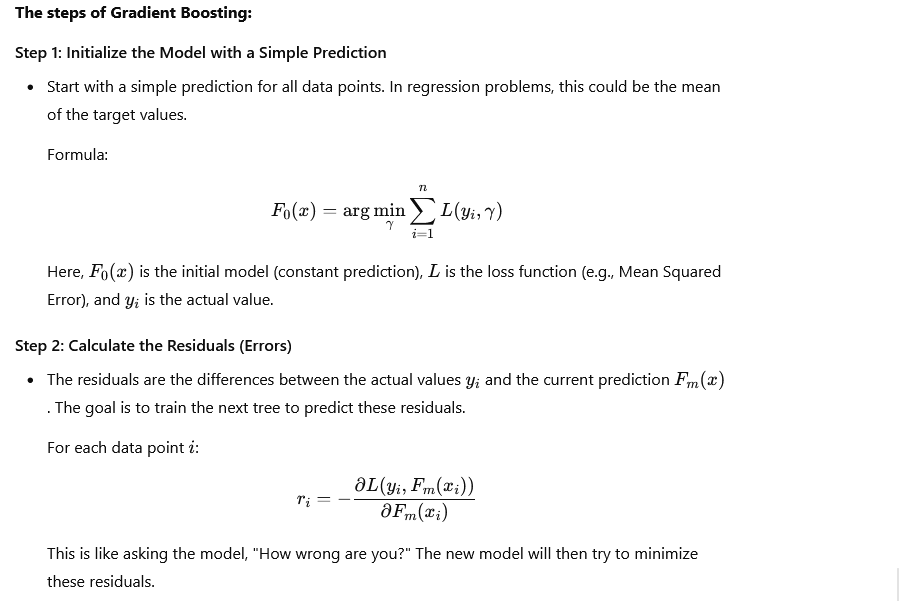

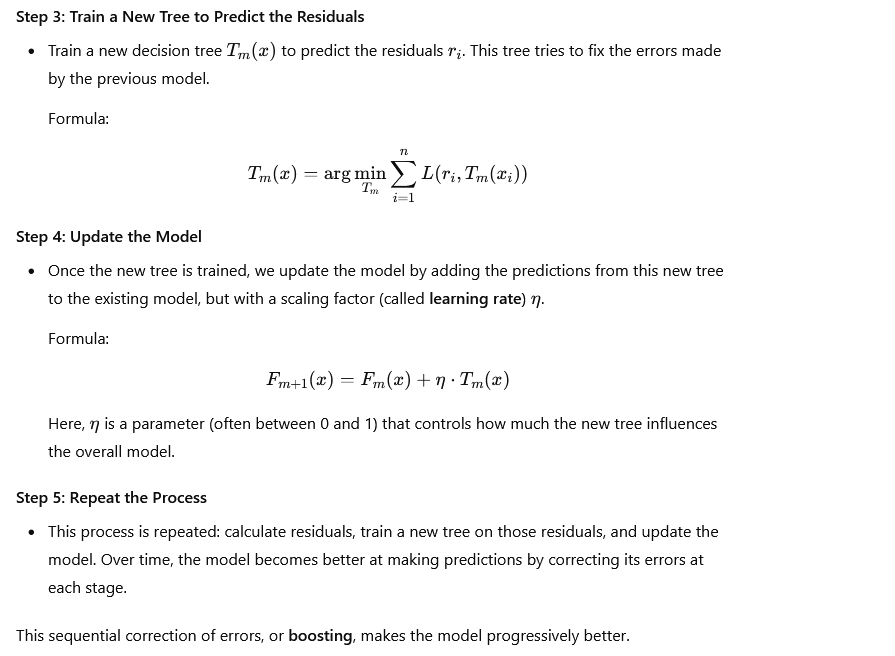

LightGBM (Light Gradient Boosting Machine) is an advanced implementation of gradient boosting trees, optimized for **speed and memory efficiency**. LightGBM introduces several enhancements to traditional Gradient Boosting, making it much faster and able to handle large datasets effectively.
Key Innovations in LightGBM:

* Leaf-wise growth: Instead of splitting nodes level-by-level (as in most tree-building methods), **LightGBM grows trees by splitting the leaf with the highest potential gain**. This approach results in deeper trees and can capture more complex patterns.

* Histogram-based binning: **LightGBM groups feature values into bins or histograms**, dramatically speeding up the search for the best split points.

* Optimized for large datasets: LightGBM can handle large-scale data efficiently, making it faster than other gradient boosting methods like XGBoost.

Boosting -> AdaBoost, Gradient Boost, XGB

Better Model: smart Feature Eng., smart Sampling

[LightGBM algorithm explained](https://www.youtube.com/watch?v=9uxWzeLglr0)

In [1]:
# Global Settings and Imports
!pip install recommenders

  Using cached pandera-0.20.4-py3-none-any.whl.metadata (15 kB)
Using cached pandera-0.20.4-py3-none-any.whl (259 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.7.1
    Uninstalling pandera-0.7.1:
      Successfully uninstalled pandera-0.7.1


In [3]:
!pip install pandera

In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


`from sklearn.preprocessing import MultiLabelBinarizer`: Imports the MultiLabelBinarizer class from scikit-learn (sklearn), a popular machine learning library. This class is used for transforming multi-label data into a binary format suitable for machine learning algorithms.


    rmse: Root Mean Squared Error
    mae: Mean Absolute Error
    rsquared: R-squared
    exp_var: Explained Variance


### 0.1 Parameter Setting
Let's set the main related parameters for LightGBM now. Basically, the task is a regression, and we are going to use the mean average error (`MAE`) as the metric to evaluate the model.

Generally, the basic parameters to adjust are the number of leaves (`MAX_LEAF`), maximum number of trees (`NUM_OF_TREES`), and the learning rate (`LEARNING_RATE`).

Besides, we can also adjust some other listed parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is shown. Also, some advice on how to tune these parameters can be found [in this url](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst).

In [7]:
# Top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"

# Other data settings
USER_COL = "userID"
ITEM_COL = "itemID"
RATING_COL = "rating"
PREDICTION_COL = "prediction"
ITEM_FEAT_COL = "genre"

# Train test split ratio
SPLIT_RATIO = 0.75

# Model settings
MAX_LEAF = 64
NUM_OF_TREES = 100
LEARNING_RATE = 0.05
METRIC = "mae"

SEED = 42

`MAX_LEAF = 64`: This sets the maximum number of leaves (terminal nodes) in each tree of the model. Limiting leaf growth can prevent overfitting.

`NUM_OF_TREES = 100`: This determines the number of trees used in the ensemble. More trees can improve accuracy but also increase training time.

`LEARNING_RATE = 0.05`: This controls the step size at each iteration while the model learns. Smaller learning rates often lead to better generalization but require more training time.

`METRIC = "mae"`: This specifies the evaluation metric for the model. "mae" stands for Mean Absolute Error, a common regression metric.

In [8]:
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": METRIC,
    "num_leaves": MAX_LEAF,
    "n_estimators": NUM_OF_TREES,
    "boost_from_average": True,
    "n_jobs": -1,
    "learning_rate": LEARNING_RATE,
}

This code defines a **dictionary** named params that stores the configuration settings for a LightGBM model. These parameters will be passed to the model constructor to customize its behavior. You'll later pass this dictionary to the LightGBM model constructor.

Here's a breakdown of the parameters:

* `"objective": "regression"`: Specifies that the model will be used for a regression task (predicting continuous values).
* `"boosting_type": "gbdt"`: Sets the boosting algorithm to Gradient Boosting Decision Tree (GBDT), a common and effective method.
* `"metric": METRIC`: Uses the METRIC variable defined earlier ("mae" in this case) as the evaluation metric during training.
* `"num_leaves": MAX_LEAF`: Sets the maximum number of leaves in each tree to the value specified in MAX_LEAF.
* `"n_estimators": NUM_OF_TREES`: Sets the number of boosting trees (or iterations) to the value in NUM_OF_TREES.
* `"boost_from_average": True`: Improves the model's starting performance by considering the average target value.
* `"n_jobs": -1`: Utilizes all available CPU cores for parallel processing, speeding up training.
* `"learning_rate": LEARNING_RATE`: Sets the learning rate to the value defined in LEARNING_RATE.

## 1. Data Preparation

In [21]:
# The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
data = movielens.load_pandas_df(
    size= MOVIELENS_DATA_SIZE,
    header=[USER_COL, ITEM_COL, RATING_COL],
    genres_col=ITEM_FEAT_COL,
)
data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 21.6kKB/s]


,userID,itemID,rating,genre
0,196,242,3.0,Comedy
1,63,242,3.0,Comedy
2,226,242,5.0,Comedy
3,154,242,3.0,Comedy
4,306,242,5.0,Comedy


#### 1.1 Encode Item Features (Genres)
To use genres from our model, we multi-hot-encode them with scikit-learn's [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

For example, *Movie id=2355* has three genres, *Animation|Children's|Comedy*, which are being converted into an integer array of the indicator value for each genre like `[0, 0, 1, 1, 1, 0, 0, 0, ...]`. In the later step, we convert this into a float array and feed into the model.

> For faster feature encoding, you may load ratings and items separately (by using `movielens.load_item_df`), encode the item-features, then combine the rating and item dataframes by using join-operation -> you did it in the `MovieLens_Data_Analysis.ipynb` Notebook

In [22]:
genres_encoder = MultiLabelBinarizer()
data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
    data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
).tolist()
print("Genres:", genres_encoder.classes_)
data.head()

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


,userID,itemID,rating,genre
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
# Expand the 'genre' list into separate columns
number_of_genres = len(genres_encoder.classes_)
number_of_genres

expanded_genre = pd.DataFrame(data[ITEM_FEAT_COL].tolist(), columns=[f"{ITEM_FEAT_COL}_{i+1}" for i in range(number_of_genres)])
expanded_genre.head()

,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Concatenate the expanded genre columns with the original DataFrame
data = pd.concat([data, expanded_genre], axis=1)

# Drop the original 'genre' column
data.drop(ITEM_FEAT_COL, axis=1, inplace=True)
data.head()

,userID,itemID,rating,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19
0,196,242,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The axis=1 argument specifies that you want to drop a column, and inplace=True modifies the DataFrame directly without creating a copy.

### 1.2 Split the data using the python random splitter provided in utilities:

**We split the full dataset into a `train` and `test` dataset to evaluate performance of the algorithm against a held-out set not seen during training.**

Because SAR generates recommendations **based on user preferences, all users that are in the test set must also exist in the training set.**

For this case, we can use the provided `python_stratified_split` function which holds out a percentage (in this case 25%) of items from each user, but ensures all users are in both `train` and `test` datasets. Other options are available in the `dataset.python_splitters` module which provide more control over how the split occurs.

When working with **LightGBM**, the choice of data splitting method depends on the type of data and the nature of the task. Here’s a breakdown of different data splitting strategies and their suitability for LightGBM:

### 1. **Random Split** (Common for Regression and Classification Tasks)
- **What it is**: In a random split, the dataset is split randomly into training and testing sets.
- **When to use**: This is suitable when the dataset is homogeneous and there are no dependencies between the data points.
- **LightGBM Consideration**: LightGBM works well with this split, as it can handle random data efficiently. If your dataset does not have temporal or sequential structure, random splitting is a good choice for evaluation. It helps ensure that the model generalizes well to unseen data.

### 2. **Stratified Split** (Used for Classification Tasks)
- **What it is**: In a stratified split, the dataset is split in such a way that the distribution of the target variable (e.g., classes in a classification problem) is maintained in both the training and test sets.
- **When to use**: This is useful for classification tasks where the classes are imbalanced.
- **LightGBM Consideration**: Stratified split can be particularly helpful when working with classification problems in LightGBM. By maintaining class balance, it prevents the model from overfitting to the majority class and ensures better performance across all classes.

### 3. **Time-based Split** (For Time Series Data)
- **What it is**: In time-based split, data is split based on time (e.g., train on past data and test on future data).
- **When to use**: This is crucial when working with sequential or time series data, where the order of data points matters.
- **LightGBM Consideration**: If you are using LightGBM for forecasting or other time-dependent tasks, it’s essential to use time-based splitting. LightGBM doesn’t inherently account for time, so you must ensure that your data splitting respects the temporal order to prevent data leakage.

### 4. **K-Fold Cross-Validation Split**
- **What it is**: The dataset is divided into `k` subsets, and the model is trained and tested `k` times, each time using a different fold as the test set while the others are used for training.
- **When to use**: This is useful for general model validation, particularly when the dataset is small or you want more robust estimates of model performance.
- **LightGBM Consideration**: LightGBM can work very well with k-fold cross-validation, as it allows the model to be evaluated on multiple train-test splits, reducing variance and overfitting risks. It also provides a more comprehensive evaluation than a single train-test split.

---

### What Split to Use for LightGBM?

For **general LightGBM tasks**:
- **Random split** or **Stratified split** (depending on whether it's a regression or classification task) is typically sufficient. These splits ensure that LightGBM has a balanced representation of data for training and testing, particularly for tasks like click-through prediction or recommendation systems.
  
For **sequential or time-dependent tasks**:
- **Time-based split** should be preferred when working with time series data or when the model’s predictions depend on the temporal sequence of data.

For **robust evaluation**:
- **K-fold cross-validation** can be highly effective in providing a better estimate of model performance.

Given the nature of **recommendation systems** (like SAR), if you’re working with **user-item interaction data**, using a split that ensures all users are present in both the training and test sets (like a stratified or random split ensuring user overlap) is crucial. This ensures the model can generalize user preferences without encountering new, unseen users in the test set.

In your course, using a **stratified split** for a **regression task** may seem unusual at first since stratified splits are typically used for classification tasks to maintain class balance. However, in the context of recommender systems (RS), the idea of stratification can be extended to ensure that the **distribution of users** or **items** is consistent across training and test sets.

Here's why this makes sense:

### Why Stratified Split in Regression for RS?

1. **Ensuring User Representation**: In a recommendation system, you’re often dealing with **user-item interactions**. Even though the task is technically a regression (predicting ratings or preferences), it’s crucial that all users have sufficient representation in both the training and test sets. The stratified split ensures that users or items with different levels of interactions (ratings or purchases) are evenly distributed between the two sets, so the model learns generalizable user preferences.

2. **Reducing Bias**: Users with fewer interactions may introduce bias if they are only present in one of the sets (train or test). By stratifying on users, you ensure that the model isn’t unfairly biased toward users with high interaction histories and can better handle the **long-tail problem**, which is common in recommender systems.

3. **Maintaining Realistic Data Distribution**: Even though it’s a regression task, a stratified split in RS helps maintain a realistic data distribution. For example, if certain users or items have a disproportionate number of interactions, stratifying can prevent one dataset (train or test) from being skewed with too many or too few examples from these frequent users/items.

### Stratified Split for RS with Regression Task:
- The split ensures that each user (or item) has a similar number of interactions in both the training and test sets.
- This way, LightGBM or any other model for regression can still learn meaningful patterns while avoiding issues that might arise from user/item imbalance in the split.

In short, in RS, even for regression tasks, a stratified split is used to ensure that each user’s or item’s data is fairly represented across training and testing, which is critical for evaluating the model's performance.

In [30]:
train, test = python_stratified_split(data, ratio=SPLIT_RATIO, col_user=USER_COL, col_item=ITEM_COL, seed=SEED)

print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train[USER_COL].unique()),
    train_items=len(train[ITEM_COL].unique()),
    test_total=len(test),
    test_users=len(test[USER_COL].unique()),
    test_items=len(test[ITEM_COL].unique()),
))


Train:
Total Ratings: 74992
Unique Users: 943
Unique Items: 1646

Test:
Total Ratings: 25008
Unique Users: 943
Unique Items: 1451



## 2. Train the LightGBM Model

`lgb`: This refers to the LightGBM library, a gradient boosting framework known for its efficiency and accuracy. Make sure you have installed it using !pip install lightgbm and imported it with import lightgbm as lgb.

`LGBMRegressor`: This is the constructor for a regression model in LightGBM. It's used when you want to predict a continuous target variable.

`params:** This indicates that you're passing a dictionary namedparamscontaining hyperparameter settings for the model. The**` operator unpacks the dictionary, passing each key-value pair as a separate argument to the constructor.


In [31]:
lgb_regressor = lgb.LGBMRegressor(**params)

In [34]:
with Timer() as train_time:
  lgb_regressor.fit(
      X=train[train.columns.difference([RATING_COL])].values,
      y=train[RATING_COL].values
      )
print(f"Took {train_time.interval} seconds for training")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 74992, number of used features: 20
[LightGBM] [Info] Start training from score 3.531430
Took 1.8744725280002967 seconds for training


`with Timer() as train_time:`: This line uses the Timer class (presumably from the recommenders library) to measure the time taken for a block of code. The with statement ensures that the timer starts running when the block begins and stops running when the block ends, even if errors occur. train_time is the variable assigned to the Timer object.

`lgb_regressor.fit(...)`: This line trains a machine learning model.

* `lgb_regressor` is an instance of the LGBMRegressor class, which is a type of gradient boosting model from the LightGBM library. These models are often used for regression tasks, like predicting a numerical value (e.g., a rating).
* `.fit(...)` is a method that trains the model using the provided data. It takes two main arguments:

        * X: **The features or independent variables used to make predictions.** In this case, it's all columns in the train DataFrame except the RATING_COL. The .values attribute converts the DataFrame to a NumPy array, which is often required by machine learning libraries.
        * y: **The target variable or the value you want to predict.** Here, it's the RATING_COL from the train DataFrame. This likely contains the actual ratings that the model will learn to predict.
* train.columns refers to all the columns in the train DataFrame.
difference([RATING_COL]) removes the column specified by the variable RATING_COL from the list of columns.
This operation ensures that the RATING_COL (which likely holds the target values, i.e., user ratings) is excluded, leaving only the feature columns (user/item features).

* `print(f"Took {train_time.interval} seconds for training")`: This line prints the time taken for the model training.

  * train_time.interval accesses the time interval recorded by the Timer object.
  * The f before the string indicates an f-string, allowing you to embed variables within curly braces {}.



## 3. Evaluate the Model

In [35]:
# Evaluate the Model
with Timer() as test_time:
  y_prediction = lgb_regressor.predict(test[test.columns.difference([RATING_COL])])
print(f"Took {test_time.interval} seconds for prediction.")

Took 0.2593007140003465 seconds for prediction.




#### Why Exclude `RATING_COL` During Training & Prediction?
- The **`RATING_COL`** represents the **target variable** — it’s what the model is trying to predict (in your case, user ratings).
- When training the model, you use the other features (such as `userID`, `itemID`, and any other features) to learn the patterns that lead to those ratings.
- Including the `RATING_COL` (the actual ratings) as an input during training or prediction would cause data leakage, where the model is being fed the correct answers, which would lead to artificially good predictions but terrible real-world performance.

Therefore, during training, we exclude the **target column** (`RATING_COL`) from the features used to train the model, and likewise, when predicting, the model only receives the **features** as input, not the actual ratings.


In [40]:
prediction = test[[USER_COL, ITEM_COL, RATING_COL]].copy()
prediction[PREDICTION_COL] = y_prediction
prediction.head(20)

,userID,itemID,rating,prediction
26975,1,48,5.0,3.905406
87870,1,149,2.0,3.861776
83701,1,103,1.0,2.700646
60240,1,49,3.0,3.546311
5678,1,194,4.0,3.947219
34323,1,153,3.0,3.653281
70614,1,213,2.0,3.805348
91087,1,41,2.0,3.549662
98510,1,130,3.0,3.258406
62414,1,230,4.0,3.428396


Are the Predictions Strange?

The predictions are not exactly the same as the actual ratings, which is expected! The job of the model is to predict ratings as closely as possible, but some error is natural. That's why we use evaluation metrics like RMSE (Root Mean Squared Error) or MAE (Mean Absolute Error) to measure how far off these predictions are from the true ratings.
Why Are the Predictions Different?

Several factors can cause your predictions to deviate from the actual ratings:

    Model performance: LightGBM or any other model won't be perfect; it will have some prediction error.
    Feature quality: How well your features represent the user-item interactions plays a big role. Are there more features like user preferences, item categories, etc., that could improve prediction?
    Hyperparameters: The tuning of LightGBM's hyperparameters (like learning rate, number of trees, etc.) can affect prediction accuracy.
    Data split: How you split the data can influence performance (especially if the training data is too small or unbalanced).

In [41]:
# Rating metrics
evaluation_rmse = rmse(test, prediction, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, col_prediction=PREDICTION_COL)
eval_mae = mae(test, prediction, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, col_prediction=PREDICTION_COL)
eval_rsquared = rsquared(test, prediction, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, col_prediction=PREDICTION_COL)
eval_exp_var = exp_var(test, prediction, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, col_prediction=PREDICTION_COL)


In [48]:
print("Model:\t LightGBM",
      "RMSE:\t%f" % evaluation_rmse,
      "MAE:\t%f" % eval_mae,
      "R2:\t%f" % eval_rsquared,
      "Exp var:%f" % eval_exp_var,
      sep='\n'
    )

Model:	 LightGBM
RMSE:	1.001431
MAE:	0.804058
R2:	0.206897
Exp var:0.206919


The performance metrics you've provided for your LightGBM model give us some insights into its effectiveness:

    RMSE (Root Mean Squared Error): An RMSE of 1.001431 suggests that, on average, the model's predictions are off by about 1 unit from the actual values. Depending on the scale of your target variable, this may or may not be considered acceptable.

    MAE (Mean Absolute Error): An MAE of 0.804058 indicates that the model's predictions deviate from the actual values by about 0.8 units on average. This is often easier to interpret than RMSE since it provides a straightforward measure of prediction error.

    R² (Coefficient of Determination): An R² value of 0.206897 means that approximately 21% of the variance in the target variable is explained by the model. This is relatively low, indicating that the model may not be capturing the underlying patterns in the data effectively.

    Explained Variance Score: The explained variance score of 0.206919 corroborates the R² value, indicating that the model's ability to explain variance is limited.

Conclusion:

    Model Effectiveness: Overall, the model appears to have limited predictive power based on the metrics. A low R² and explained variance suggest that there might be significant unexplained variability in the target variable.